### SIR-X

Implementation of the epidemic model SIR-X. It considers a time-dependent transmission rate.

Bibliography: [Robert Koch Institut](http://rocs.hu-berlin.de/corona/docs/forecast/model/#sir-x-dynamics-outbreaks-with-temporally-increasing-interventions)

In [11]:
import numpy as np # Numerical computing
import matplotlib.pyplot as plt # Visualization
from scipy.integrate import odeint # ODE system numerical integrator

In [13]:
def sirx(w, t, p):
    """ SIR-X: Dynamic outbreaks with temporally increasing
    interventions
    
    inputs:
    w: vector of state variables [S,I,R,X]
    S: Fraction of the population susceptible to the infection
    I: Fraction on the population infected
    R: Fraction of the population that recovered
    
    returns:
    f: right hand side of the system of differential equations
    """
    # Unpack state variables
    S, I, R, X = w
    # Unpack parameters
    alpha, beta, kappa_0, kappa = p
    dS_dt = -alpha*S*I - kappa_0*S
    dI_dt =  alpha*S*I - beta*I - kappa_0*I - kappa*I
    dR_dt = (kappa_0 + kappa) * I
    dX_dt = kappa_0*S + beta * I
    
    f = [dS_dt, dI_dt, dR_dt, dX_dt]
    return f

In [14]:
# Call the ODE solver.
beta = 0.38/(3600*24) # Per day
alpha = 2.5 * beta # Reproduction number
kappa_0 = 0 # Simple SIR to begin 
kappa = 0   # Simple SIR to begin

p = [alpha, beta, kappa_0, kappa]

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
stoptime = 3600*24*7
numpoints = 250

# Use Ealing values

P_Ealing = 200000 # Ealing population
I_Ealing = 200    # Infected people at 28/03/2020
S0 = (P_Ealing-I_Ealing)/P_Ealing
I0 = I_Ealing/P_Ealing
R0 = 0   # Recovered people
X0 = 0      # Quarantined people

w0 = [S0, I0, R0, X0]

t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

wsol = odeint(sirx, w0, t, args=(p,),
              atol=abserr, rtol=relerr)

In [15]:
# Unpack the solution
S = wsol[:,0]
I = wsol[:,1]
R = wsol[:,2]
X = wsol[:,3]

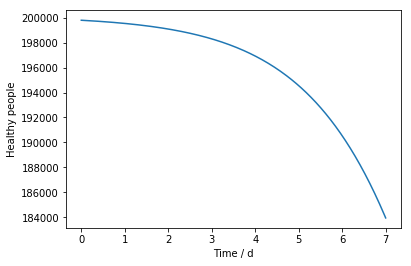

In [16]:
tt = np.linspace(0,7,len(S))
plt.plot(tt,S*P_Ealing)
plt.ylabel("Healthy people")
plt.xlabel("Time / d")
plt.show()

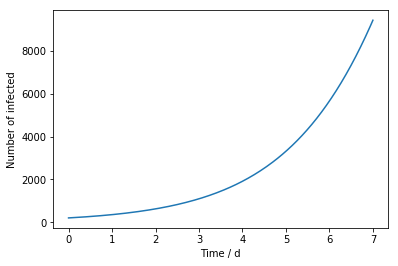

In [17]:
tt = np.linspace(0,7,len(I))
plt.plot(tt,I*P_Ealing)
plt.ylabel("Number of infected")
plt.xlabel("Time / d")
plt.show()

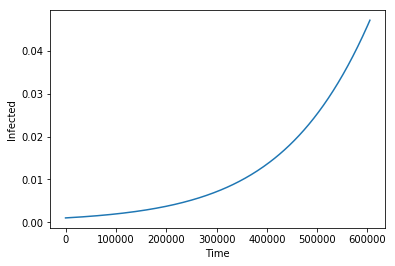

In [18]:
plt.plot(t,I)
plt.ylabel("Infected")
plt.xlabel("Time")
plt.show()

### Encapsular en una función con valores por defecto. 

Escribir una API con eso